In [1]:
import numpy as np
import pandas as pd
import lxml.etree as etree
import sqlite3 as sql
from process import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, precision_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [3]:
data = pd.read_csv('../data/prem_data_elo.csv', index_col = 'Unnamed: 0')
data.head()

,match_api_id,league_id,date,home_team_api_id,home_team_name,away_team_api_id,away_team_name,home_team_goal,away_team_goal,home_team_foul_reason_from_behind,...,away_team_card_reason_pushing,home_team_card_reason_diving,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt,result,home_elo,away_elo
0,489044,1729,2008-08-16 00:00:00,8472,Sunderland,8650,Liverpool,0,2,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
1,489045,1729,2008-08-16 00:00:00,8654,West Ham United,8528,Wigan Athletic,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
2,489047,1729,2008-08-16 00:00:00,8668,Everton,8655,Blackburn Rovers,2,12,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
3,489048,1729,2008-08-16 00:00:00,8549,Middlesbrough,8586,Tottenham Hotspur,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
4,489049,1729,2008-08-16 00:00:00,8559,Bolton Wanderers,10194,Stoke City,3,4,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0


In [4]:
X = data[data.columns[9:]].drop(
    ['result', 'home_elo', 'away_elo'],
axis = 1)
y = data['result']

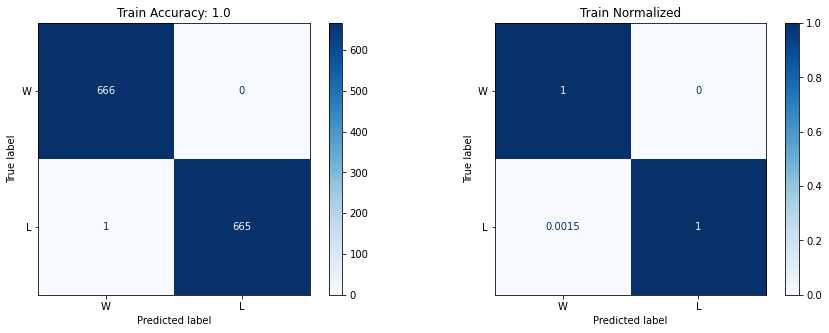

   Class  Accuracy  Precision    Recall        F1  Support
0      W  1.000000   0.998501  1.000000  0.999250      666
1      L  0.998498   1.000000  0.998498  0.999249      666
2  Total  0.999249   0.999250  0.999249  0.999249     1332


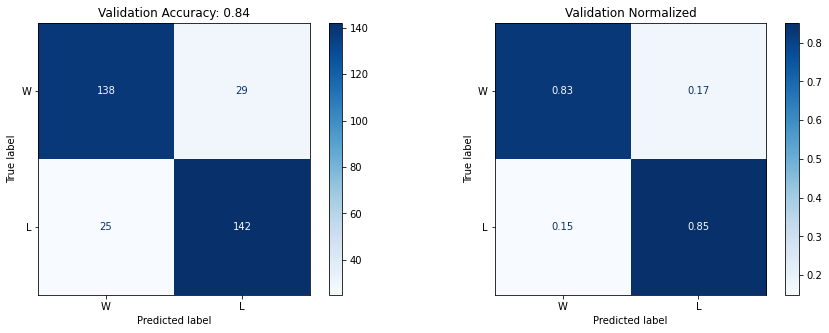

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.826347   0.846626  0.826347  0.836364      167
1      L  0.850299   0.830409  0.850299  0.840237      167
2  Total  0.838323   0.838518  0.838323  0.838300      334


In [7]:
X_ds, y_ds, weights = transform_target(X, y, class_labels = ['W', 'L'], weight = True, down_sample = True)
X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size = 0.2, stratify = y_ds)

clf = RFpipe(weights = weights).fit(X_train, y_train)
print(metric_suite(clf, X_train, y_train, labels = ['W', 'L'], type_ = 'Train', cm = True, save = 'train_cm.png'))
print(metric_suite(clf, X_test, y_test, labels = ['W', 'L'], type_ = 'Validation', cm = True, save = 'valid_cm.png'))

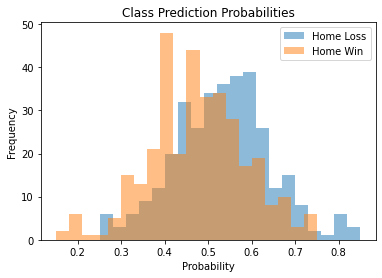

In [66]:
plt.hist(clf['rf'].predict_proba(X_test.values)[:, 0], alpha = 0.5, bins = 20)
plt.hist(clf['rf'].predict_proba(X_test.values)[:, 1], alpha = 0.5, bins = 20)
plt.legend(labels = ['Home Loss', 'Home Win'])
plt.title('Class Prediction Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.savefig('rf_class_probs.png', dpi = 200)
plt.show()

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import DecisionBoundaryDisplay

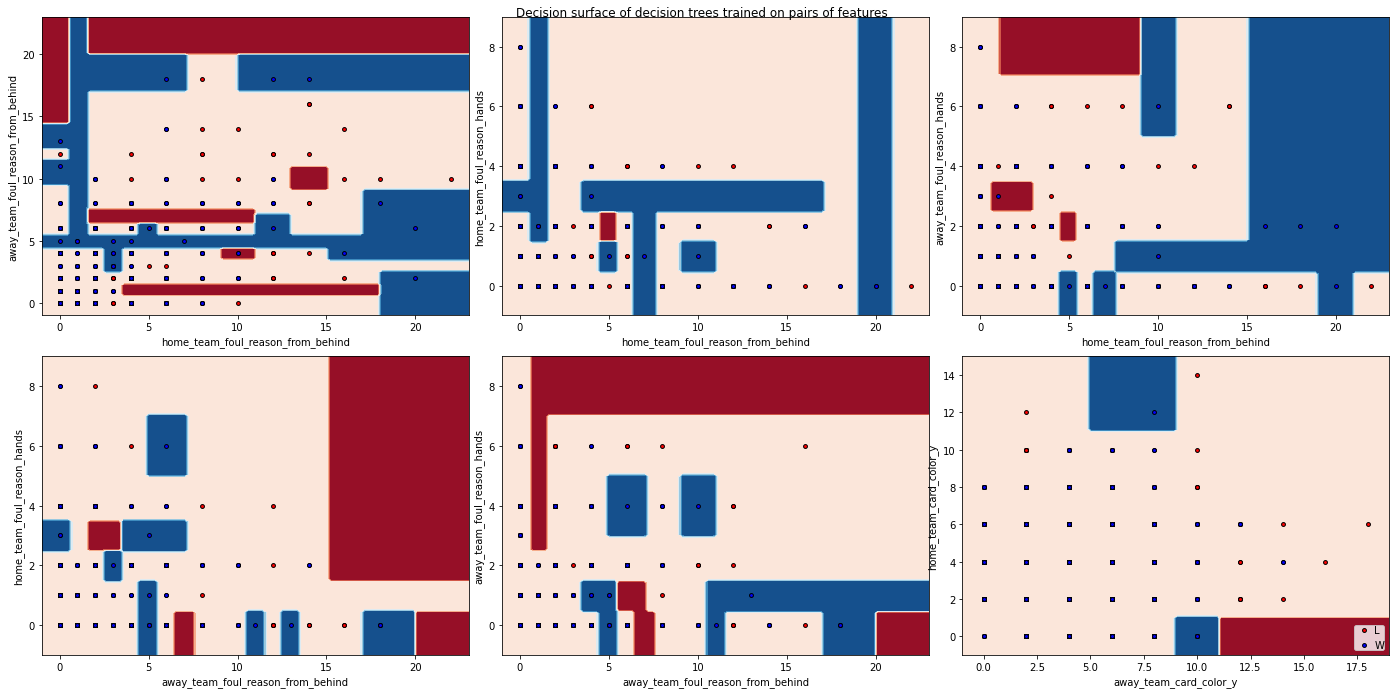

In [89]:
# Parameters
n_classes = 2
plot_colors = "rb"
plot_step = 1

fig, axs = plt.subplots(2, 3, figsize = (20,10))
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [27, 26]]):
    # We only take the two corresponding features
    X_ = X.values[:, pair]
    y_ = y
    
    pipe = Pipeline(steps = [
        ('scaler', StandardScaler()),
        ('rf', DecisionTreeClassifier(class_weight = weights))
    ])

    # Train
    clf2 = pipe.fit(X_, y_)

    # Plot the decision boundary
    #ax = plt.subplot(2, 3, pairidx + 1)
    ax = axs.flat[pairidx]
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    DecisionBoundaryDisplay.from_estimator(
        clf2,
        X_,
        cmap=plt.cm.RdBu,
        response_method="predict",
        ax=ax,
        xlabel=X.columns[pair[0]],
        ylabel=X.columns[pair[1]],
    )

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_ == ['L', 'W'][i])
        ax.scatter(
            X_[idx, 0],
            X_[idx, 1],
            c=color,
            label=['L', 'W'][i],
            cmap=plt.cm.RdBu,
            edgecolor="black",
            s=15,
        )

plt.suptitle("Decision surface of decision trees trained on pairs of features")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
_ = plt.axis("tight")

In [84]:
np.where(np.array(X.columns) == 'away_team_card_color_y')

(array([27]),)